# Regresión logística

Ya sabemos cómo funciona una red neuronal y ya sabemos implementarla mediante Pytorch, así que vamos a empezar a ver el ejemplo más sencillo de una red neuronal, la regresión logística.

Supongamos que tenemos la siguiente distribución de puntos

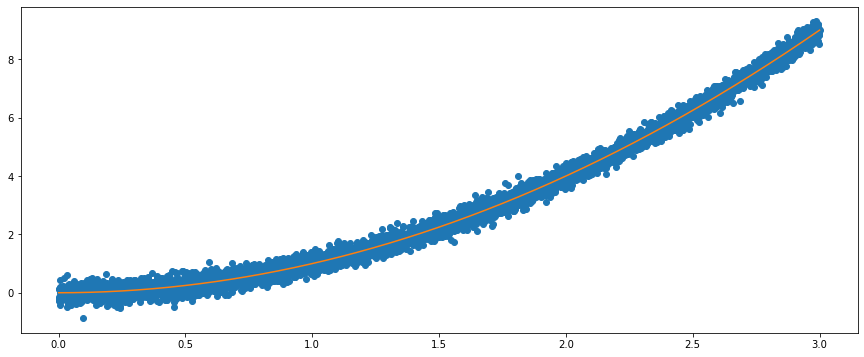

In [207]:
import numpy as np
import matplotlib.pyplot as plt

# Numpy array of random numbers from 0 to 20
size = 5000
x = np.linspace(0, 3, size)
y = x**2#3*np.sin(2*np.pi*x)**5 + 4*np.sin(2*np.pi*x)**3 - 8*np.cos(2*np.pi*x)**2
y_noise = y + 0.2*np.random.randn(size)

# plot of x-y
plt.figure(figsize=(15, 6))
plt.plot(x, y_noise, 'o')
plt.plot(x, y)
plt.show()


La línea naranja corresponde a la función que se debería obtener, pero supongamos que hemos hecho unas medidas y teníamos ruido, así que obtenemos los puntos azules

En el caso de la regresión logística se usan las redes neuronales para dar un número real en función de una entrada dada. Así qye vamos a crear una red neuronal que mediante los datos dados sea capaz de generar una salida válida

## División de los datos en train y validacion

Para poder entrenar hemos visto que necesitamos dividir los datos en un conjunto de datos de entrenamiento y en un conjunto de datos de validación. Así que dividimos nuestros datos en estos dos conjuntos.

Cogémos los dos primeros lóbulos para entrenamiento y el último lóbulo para validación

In [208]:
porcentaje = 0.68

# Conjunto de entrenamiento
x_train = x[:int(porcentaje*size)]
y_train = y_noise[:int(porcentaje*size)]

# Conjunto de validacion
x_valid = x[int(porcentaje*size):]
y_valid = y_noise[int(porcentaje*size):]

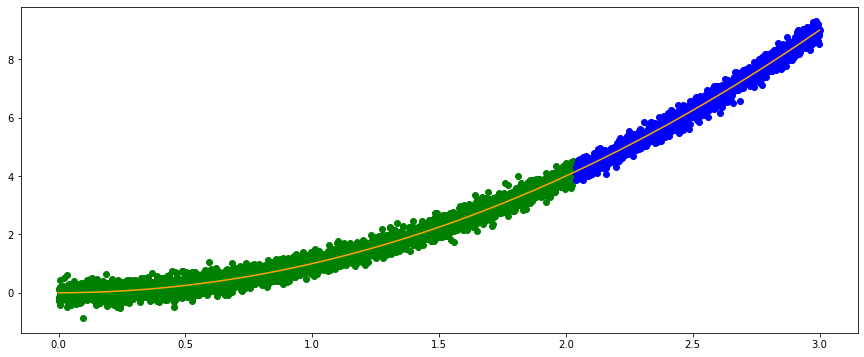

In [209]:
# Representamos los dos conjuntos en distintos colores
plt.figure(figsize=(15, 6))
plt.plot(x_train, y_train, 'o', color='green')
plt.plot(x_valid, y_valid, 'o', color='blue')
plt.plot(x, y, color='orange')
plt.show()

## Dataset y Dataloader

In [210]:
import torch

In [211]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.x)

In [212]:
ds_train = Dataset(x_train, y_train)
ds_valid = Dataset(x_valid, y_valid)

In [213]:
len(ds_train), len(ds_valid)

(3400, 1600)

In [214]:
from torch.utils.data import DataLoader

BS = 64

dl_train = DataLoader(ds_train, batch_size=BS, shuffle=True)
dl_valid = DataLoader(ds_valid, batch_size=BS, shuffle=True)

## Red Neuronal

Creamos una red neuronal para entrenarla

In [215]:
from torch import nn

class NeuralNetwork(nn.Module):
    def __init__(self, batch_size=BS):
        super(NeuralNetwork, self).__init__()
        self.network = torch.nn.Sequential(
            nn.Linear(batch_size, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, batch_size),
        )

    def forward(self, x):
        logits = self.network(x)
        return logits

In [216]:
model = NeuralNetwork()

In [217]:
sample_x, sample_y = next(iter(dl_train))
preds = model(sample_x)
preds

tensor([-0.0249,  0.1458, -0.2661, -0.1009,  0.1352, -0.3996, -0.2021, -0.1982,
        -0.0997,  0.0488, -0.0778,  0.0749,  0.1566, -0.1600, -0.1473,  0.1747,
        -0.0964, -0.0696,  0.0099, -0.1352, -0.2541,  0.2046,  0.2679,  0.0146,
         0.1030, -0.1802, -0.1472, -0.2980, -0.0114, -0.0360,  0.0585, -0.1450,
        -0.1223,  0.0968, -0.1472,  0.0795,  0.0030,  0.1848, -0.1269,  0.0090,
        -0.0704,  0.0488,  0.0161,  0.0049,  0.1344,  0.1259, -0.2751,  0.1561,
        -0.1755, -0.1795,  0.0652, -0.1382, -0.2394,  0.1646,  0.0520, -0.0744,
         0.0878,  0.0260, -0.0462,  0.0083,  0.0022, -0.1533, -0.3147, -0.0215],
       grad_fn=<AddBackward0>)

Si se puede se manda a la GPU

In [218]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

model.to(device)

Using cuda device


NeuralNetwork(
  (network): Sequential(
    (0): Linear(in_features=64, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=64, bias=True)
  )
)

## Función de pérdida y optimizador

Definimos una función de pérdida y un optimizador

In [228]:
LR = 1e-3

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)


## Ciclo de entrenamiento

Entrenamos la red

In [229]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Add padding if is necessary (for last batch)
        if X.shape[0] < BS:
            zeros = torch.zeros(BS - X.shape[0], dtype=torch.float32)
            X = torch.cat((X, zeros), dim=0)
            y = torch.cat((y, zeros), dim=0)

        # X and y to device
        X, y = X.to(device), y.to(device)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 50 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    test_loss = 0
    
    with torch.no_grad():
        for X, y in dataloader:
            # X and y to device
            X, y = X.to(device), y.to(device)
            
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")

In [230]:
epochs = 150
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(dl_train, model, loss_fn, optimizer)
    test_loop(dl_valid, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: -0.273554  [    0/ 3400]
loss: -0.047017  [ 3200/ 3400]
Test Error: 
 Avg loss: -20.226594 

Epoch 2
-------------------------------
loss: -0.699551  [    0/ 3400]
loss: -0.853561  [ 3200/ 3400]
Test Error: 
 Avg loss: -22.520221 

Epoch 3
-------------------------------
loss: -0.843478  [    0/ 3400]
loss: -1.212290  [ 3200/ 3400]
Test Error: 
 Avg loss: -25.114115 

Epoch 4
-------------------------------
loss: -1.191641  [    0/ 3400]
loss: -0.609330  [ 3200/ 3400]
Test Error: 
 Avg loss: -27.921892 

Epoch 5
-------------------------------
loss: -0.907426  [    0/ 3400]
loss: -1.238314  [ 3200/ 3400]
Test Error: 
 Avg loss: -31.006580 

Epoch 6
-------------------------------
loss: -0.645159  [    0/ 3400]
loss: -2.059995  [ 3200/ 3400]
Test Error: 
 Avg loss: -34.424899 

Epoch 7
-------------------------------
loss: -0.426636  [    0/ 3400]
loss: -0.302347  [ 3200/ 3400]
Test Error: 
 Avg loss: -38.227306 

Epoch 8
-------------------

## Inferencia

In [231]:
dl_valid = DataLoader(ds_valid, batch_size=BS, shuffle=True)

In [232]:
def inference_loop(dataloader, model):
    inference_output = torch.empty(0).to(device)
    
    with torch.no_grad():
        for X, y in dataloader:
            # X and y to device
            X, y = X.to(device), y.to(device)
            
            pred = model(X)
            inference_output = torch.cat((inference_output, pred), dim=0)
            
    return inference_output.to("cpu")

inference = inference_loop(dl_valid, model)

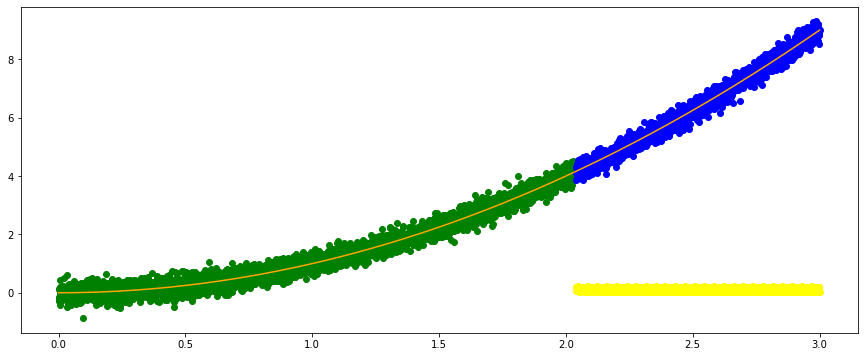

In [233]:
# Representamos los dos conjuntos en distintos colores
plt.figure(figsize=(15, 6))
plt.plot(x_train, y_train, 'o', color='green')
plt.plot(x_valid, y_valid, 'o', color='blue')
plt.plot(x_valid, inference, 'o', color='yellow')
plt.plot(x, y, color='orange')
plt.show()